In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import SGDRegressor
from scipy.spatial.distance import cdist
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np

# Classificador não supervisionado K-Means - Adult.csv

In [2]:
df = pd.read_csv("adult.csv.txt", sep=",")
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

### Remove coluna "education"(utiliza a coluna "education-num", já codificada) e "fnlwgt"

In [3]:
df = df.drop(["education", "fnlwgt"],axis=1)
df = df[df.workclass!='?']

### Codifica as colunas categóricas

In [4]:
le = preprocessing.LabelEncoder()

In [5]:
df.workclass = le.fit_transform(df.workclass)
df['marital-status'] = le.fit_transform(df['marital-status'])
df.occupation = le.fit_transform(df.occupation)
df.relationship = le.fit_transform(df.relationship)
df.race = le.fit_transform(df.race)
df.gender = le.fit_transform(df.gender)
df['native-country'] = le.fit_transform(df['native-country'])

### Kmeans

In [6]:
X = df.drop(["income"], axis=1)
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
df['kmeans'] = y_kmeans
df.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,kmeans
0,25,3,7,4,7,3,2,1,0,0,40,39,<=50K,0
1,38,3,9,2,5,0,4,1,0,0,50,39,<=50K,0
2,28,1,12,2,11,0,4,1,0,0,40,39,>50K,0
3,44,3,10,2,7,0,2,1,7688,0,40,39,>50K,0
5,34,3,6,4,8,1,4,1,0,0,30,39,<=50K,0


### Número de acertos

In [7]:
somaAcertos = ((df.income == ">50K") == df.kmeans).sum() 
somaAcertos/len(df.income)

0.7571183458940556

### Elbow method to optimal K value

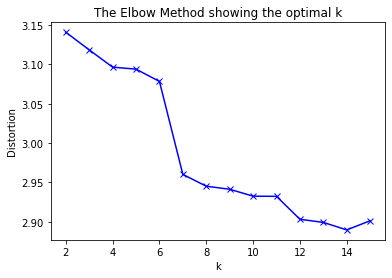

In [8]:
distortions = []

K = range(2,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    #distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'mahalanobis'), axis=1)) / X.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Classificador Supervisionado

In [9]:
df = df.drop(["kmeans"],axis=1)

In [10]:
def calc_rss(y, predicted):
    return float(((predicted - y) ** 2).sum())

def calc_r2(y, predicted):
    return r2_score(predicted,y) 

In [11]:
df['income'] = le.fit_transform(df['income'])
le.inverse_transform([0,1])

array(['<=50K', '>50K'], dtype=object)

In [12]:
X = df.drop(["income"], axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True)

In [13]:
pknn = Pipeline([('scl', StandardScaler()), ('rgs', KNeighborsRegressor(n_neighbors=5))])
ptree = Pipeline([('scl', StandardScaler()), ('rgs', DecisionTreeRegressor())])
psgdr = Pipeline([('scl', StandardScaler()), ('rgs', SGDRegressor())])

pipelines = [pknn, ptree, psgdr]

pipe_names = {0:"KNN", 1:"Árvore de Decisão", 2:"SGDR"}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

print("    Test Accuracy\n")
scores = []
for idx, val in enumerate(pipelines):
    sc = val.score(X_test, y_test)
    scores.append(sc)
    print("%s: %.3f" % (pipe_names[idx], sc))
    
max_ind = scores.index(max(scores))
print("\nRegression with best accuracy: ", pipe_names[max_ind])

    Test Accuracy

KNN: 0.325
Árvore de Decisão: 0.037
SGDR: 0.250

Regression with best accuracy:  KNN


In [14]:
pred_test = pipelines[max_ind].predict(X_test)

print("RSS = ", calc_rss(y_test, pred_test))
print("R2 = ", calc_r2(y_test, pred_test))

RSS =  1744.9200000000003
R2 =  -0.21064192233457346
